# Import library & function

In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import seaborn as sns

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import FuncFormatter 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
pd.set_option('display.max_rows', 10)
sns.set(font_scale=1.4)

# Import raw data

In [9]:
ac3 = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/raw_ac.csv')
ac3['DateTime'] = pd.to_datetime(ac3['DateTime'],dayfirst=True)
ac3.index = ac3['DateTime']
ac3 = ac3.drop(['DateTime'],axis=1)
ac3 = ac3.rename(columns={"raw/aircon3/monitor/energy": "AC3"})
# convert energy to power (kW)
ac3.iloc[:,0]= ac3.iloc[:,0]*60/1000
print(ac3.info())
ac3

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 670581 entries, 2018-01-01 00:01:00 to 2019-05-31 23:59:00
Data columns (total 1 columns):
AC3    670581 non-null float64
dtypes: float64(1)
memory usage: 10.2 MB
None


,AC3
DateTime,
2018-01-01 00:01:00,0.00204
2018-01-01 00:02:00,0.00204
2018-01-01 00:03:00,0.00204
2018-01-01 00:04:00,0.00204
2018-01-01 00:05:00,0.00204
...,...
2019-05-31 23:55:00,0.00234
2019-05-31 23:56:00,0.00228
2019-05-31 23:57:00,0.00234


# Data pre-processing process

<font size="3">
There are five-step of data pre-processing process including:
<br>
<br>
1. Drop duplicate value and NaN value 
<br>
2. Drop out of range value
<br>
3. Drop outlier using interquartile range (IQR)
<br>
4. Imputation using linear interpolation
<br>
5. Down-sampling to hourly basis using averaging
</font>

In [10]:
ac3_clean = ac3

# Drop NaN values
ac3_clean = ac3_clean.dropna()

# Remove duplicated values
ac3_clean = ac3_clean[~ac3_clean.index.duplicated()]

# Drop out of range value
ac3_clean['AC3'] = ac3_clean['AC3'].mask(ac3_clean['AC3'] < 0, 0)
ac3_clean['AC3'] = ac3_clean['AC3'].mask(ac3_clean['AC3'] > 3, np.nan)

# Drop outliers using IQR
Q1 = ac3_clean['AC3'].quantile(0.25)
Q3 = ac3_clean['AC3'].quantile(0.75)
IQR = Q3 - Q1
ac3_clean['AC3'] = ac3_clean['AC3'][~((ac3_clean['AC3'] < (Q1-1.5*IQR)) |(ac3_clean['AC3'] > (Q3+1.5*IQR)))]

# Impute missing values using linear interpolation approach
ac3_clean = ac3_clean.interpolate(method='linear')

# Down-sampling data from raw sampling period to houly basis using averaging
ac3_clean = ac3_clean.resample('1h').mean()
ac3_clean = ac3_clean.dropna()

print(ac3_clean.info())
ac3_clean

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11302 entries, 2018-01-01 00:00:00 to 2019-05-31 23:00:00
Data columns (total 1 columns):
AC3    11302 non-null float64
dtypes: float64(1)
memory usage: 176.6 KB
None


,AC3
DateTime,
2018-01-01 00:00:00,0.002098
2018-01-01 01:00:00,0.002097
2018-01-01 02:00:00,0.002115
2018-01-01 03:00:00,0.002080
2018-01-01 04:00:00,0.002015
...,...
2019-05-31 19:00:00,0.002291
2019-05-31 20:00:00,0.002328
2019-05-31 21:00:00,0.002346


# Pre-processed data results

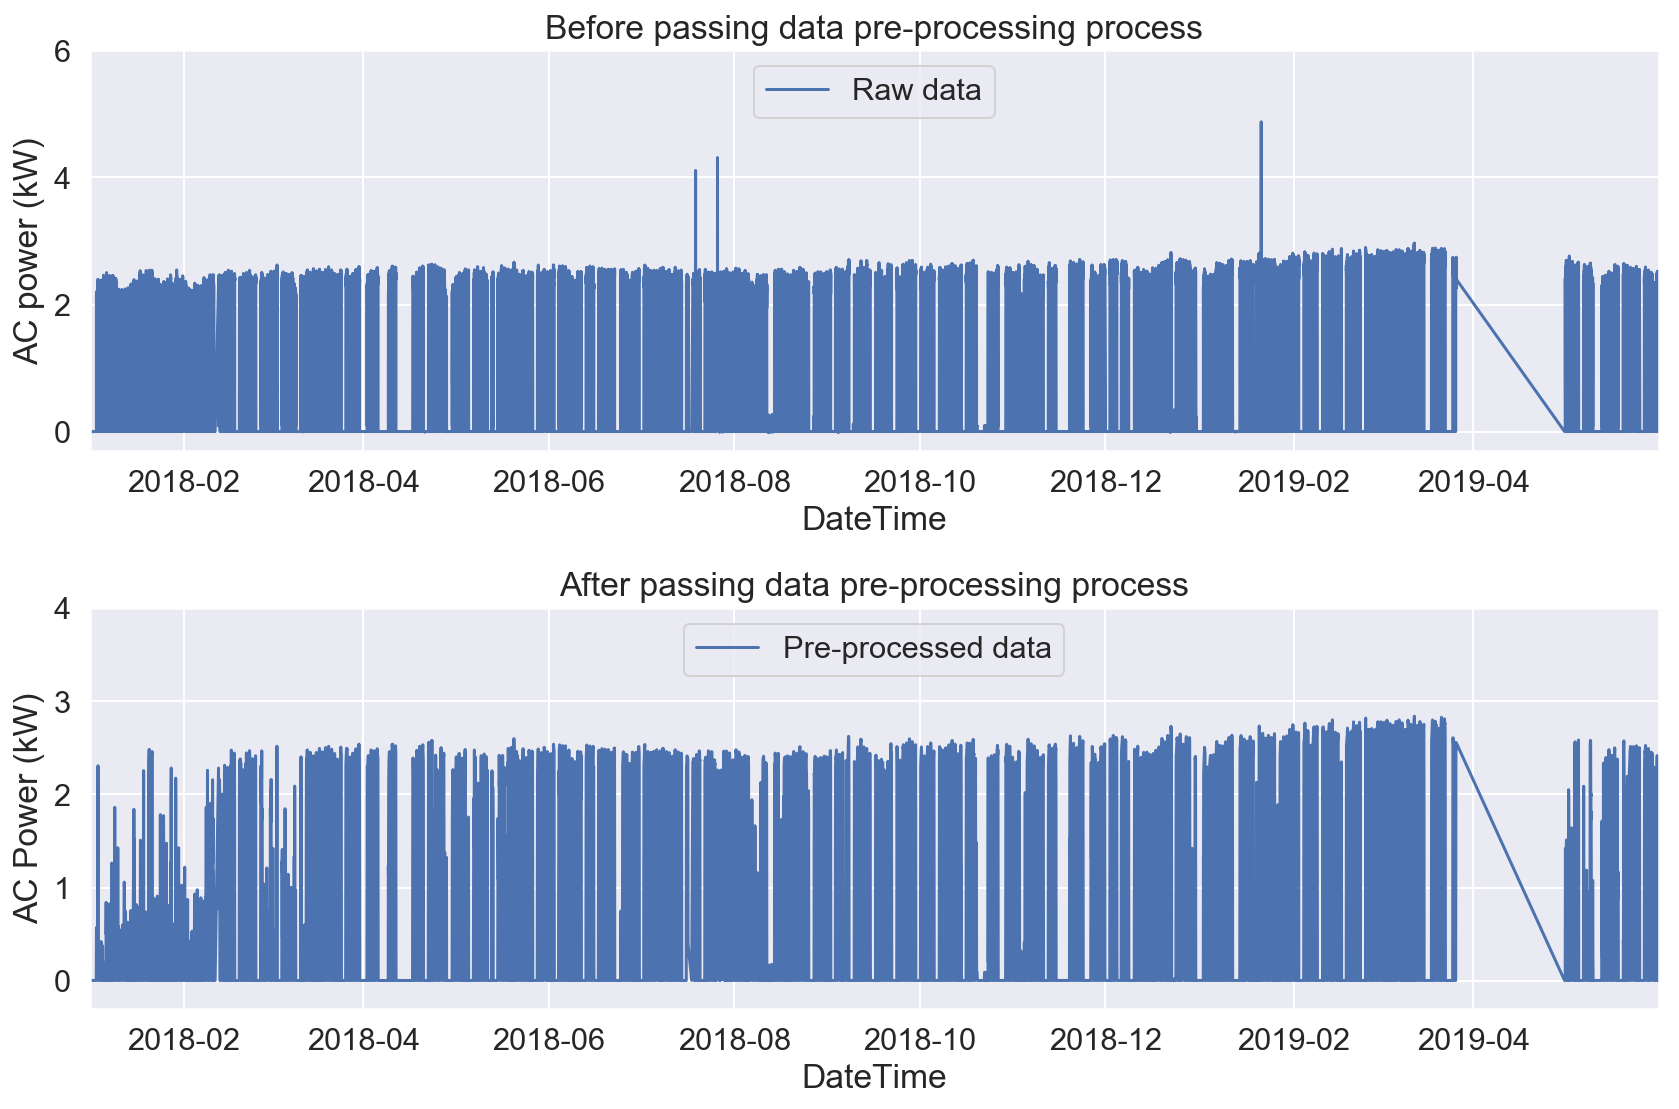

In [11]:
register_matplotlib_converters()
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))
ax1, ax2 = axes.flatten()

ax1.plot(ac3.index, ac3['AC3'],label='Raw data')
ax1.set_xlabel('Control time step')
ax1.axis([ac3.index[0],ac3.index[-1], -0.3, 6])
ax1.set_ylabel('AC power (kW)')
ax1.set_xlabel('DateTime')
ax1.set_title('Before passing data pre-processing process')
ax1.legend(loc='upper center')
ax1.grid(True)

ax2.plot(ac3_clean.index, ac3_clean['AC3'], label='Pre-processed data')
ax2.axis([ac3_clean.index[0],ac3_clean.index[-1],-0.3, 4])
ax2.set_ylabel('AC Power (kW)')
ax2.set_xlabel('DateTime')
ax2.set_title('After passing data pre-processing process')
ax2.legend(loc='upper center')
ax2.grid(True)

plt.tight_layout()
plt.show();